In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from scipy import stats
from scipy.stats import norm,skew
import warnings
from sklearn.preprocessing import RobustScaler
warnings.filterwarnings("ignore")
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential  
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import r2_score

# 讀取數據
data_path = '資料/水位雨量資料/1510H057.csv'   
data = pd.read_csv(data_path)

# 定義 時間索引 欄位
def create_timestamp(data):
    # 將"Date"和"Time"合併成時間戳記並設置為索引
    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
    data = data.set_index('Timestamp')
    return data

# 原始資料加入時間索引
data = create_timestamp(data)
print (data)
data.head(5)



                           Date   Time  1510H057 Water Level  19335 Rainfall
Timestamp                                                                   
2020-01-01 00:00:00    2020/1/1  00:00                 88.47        0.000000
2020-01-01 01:00:00    2020/1/1  01:00                 88.79        0.000000
2020-01-01 02:00:00    2020/1/1  02:00                 88.78        0.000000
2020-01-01 03:00:00    2020/1/1  03:00                 88.84        0.000000
2020-01-01 04:00:00    2020/1/1  04:00                 88.81        1.428012
...                         ...    ...                   ...             ...
2022-12-31 19:00:00  2022/12/31  19:00                 88.83        0.000000
2022-12-31 20:00:00  2022/12/31  20:00                 88.82        0.000000
2022-12-31 21:00:00  2022/12/31  21:00                 88.80        0.055771
2022-12-31 22:00:00  2022/12/31  22:00                 88.81        0.000000
2022-12-31 23:00:00  2022/12/31  23:00                 88.81        0.014507

,Date,Time,1510H057 Water Level,19335 Rainfall
Timestamp,,,,
2020-01-01 00:00:00,2020/1/1,00:00,88.47,0.000000
2020-01-01 01:00:00,2020/1/1,01:00,88.79,0.000000
2020-01-01 02:00:00,2020/1/1,02:00,88.78,0.000000
2020-01-01 03:00:00,2020/1/1,03:00,88.84,0.000000
2020-01-01 04:00:00,2020/1/1,04:00,88.81,1.428012


In [2]:
# 水位四捨五入小數第一位
data['1510H057 Water Level'] = data['1510H057 Water Level'].round(2)
# -------------------------------------------------------------------------------------------------------------------
# 列出所有要增加特徵的欄位名稱
columns_to_expand = ["1510H057 Water Level","19335 Rainfall"]

# 1.產出_T-1到_T-72的特徵
for col in columns_to_expand:
    for t in range(1, 73):
        new_col_name = f"{col}_T-{t}"
        data[new_col_name] = data[col].shift(t)
# -------------------------------------------------------------------------------------------------------------------       
# 2.產出每個月的平均水位
monthly_mean = data.groupby(data.index.month)[f"1510H057 Water Level"].mean()
#  創建一個新列，其中包含每個時間戳記與其對應月份的平均水位
data[f"1510H057 Water Level_monthly_mean"] = data.index.month.map(monthly_mean)
# -------------------------------------------------------------------------------------------------------------------
# 3. 創建水位距平值：當前水位(T-0)和(T-1~T-72)與月平均水位的差值
data[f"1510H057 Water Level_distance"] = data[f"1510H057 Water Level"] - data[f"1510H057 Water Level_monthly_mean"]

for t in range(1, 73):
    new_col_name = f"1510H057 Water Level_distance_T-{t}"
    data[new_col_name] = data["1510H057 Water Level_distance"].shift(t) 
# -------------------------------------------------------------------------------------------------------------------
# 4.計算3、6、9、12、24、48、72小時的累積雨量
time_intervals = [3, 6, 9, 12, 24, 48, 72]

for interval in time_intervals:
    col_name = f"19335 Rainfall_{interval}h_cumsum"
    data[col_name] = data["19335 Rainfall"].rolling(window=interval).sum()
# -------------------------------------------------------------------------------------------------------------------
# 5.增加T+1的雨量
for station in ["19335 Rainfall"]:
    col = f"{station}"
    for t in range(1,2):
        future_col_name = f"{col}_T+{t}"
        data[future_col_name] = data[col].shift(-t)
        
# 刪除包含NaN的行
data = data.dropna()
# 刪除不必要的列
data = data.drop(['Date', 'Time'], axis=1)  
print(data)

                     1510H057 Water Level  19335 Rainfall  \
Timestamp                                                   
2020-01-04 00:00:00                 88.14        0.000000   
2020-01-04 01:00:00                 88.17        0.000000   
2020-01-04 02:00:00                 88.17        0.000000   
2020-01-04 03:00:00                 88.17        0.000000   
2020-01-04 04:00:00                 88.17        0.000000   
...                                   ...             ...   
2022-12-31 18:00:00                 88.83        0.000000   
2022-12-31 19:00:00                 88.83        0.000000   
2022-12-31 20:00:00                 88.82        0.000000   
2022-12-31 21:00:00                 88.80        0.055771   
2022-12-31 22:00:00                 88.81        0.000000   

                     1510H057 Water Level_T-1  1510H057 Water Level_T-2  \
Timestamp                                                                 
2020-01-04 00:00:00                     88.19           

In [ ]:
# 特徵輸出

df = pd.DataFrame(data)

df.to_csv('資料.csv', index=True)  # 如果不想保留索引，可以將 index 參數設為 False

In [3]:
# 標準化
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data)
scaled_data = pd.DataFrame(scaled_features, columns=data.columns, index=data.index)

In [4]:
# 列出目標水位列
target_columns = ["1510H057 Water Level"]

# 增加目標列：T+1的目標水位
for target_col in target_columns:
    for t in range(1, 2):
        target = f'{target_col}_target_{t}'
        scaled_data[target] = data[target_col].shift(-t)

# 移除含有 NaN 的行
scaled_data = scaled_data.dropna()

In [ ]:
# scaled_data

In [ ]:
# # 使用 RandomizedSearchCV 選取區間最佳化參數
# from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
# from scipy.stats import uniform, randint
# import lightgbm as lgb

# # 切分數據為訓練和測試集
# X = scaled_data.drop([f'1510H057 Water Level_target_1'], axis=1)  # 特徵
# y = scaled_data[f'1510H057 Water Level_target_1']  # 目標變數

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# tscv = TimeSeriesSplit(n_splits=5)

# # 定義參數的範圍
# param_dist = {
#     'objective': ['regression'],  # 回歸問題
#     'num_leaves': randint(24, 35),  # 樹的最大葉子數
#     'learning_rate': uniform(0.01, 0.03),  # 學習率
#     'n_estimators': randint(650, 760),  # 樹的數量
#     'max_bin': randint(30, 50),  # 最大bin數量
#     'subsample': uniform(0.7, 0.85),  # 子樣本比例
#     'subsample_freq': randint(2, 5),  # 子樣本選擇頻率
#     'colsample_bytree': uniform(0.7, 0.85),  # 每棵樹使用特徵的比例
#     'min_child_samples': randint(4, 7),  # 每個葉子節點上的最小樣本數
#     'min_child_weight': randint(10, 13),  # 最小子節點權重和
#     'device': ['gpu'],  # 使用GPU進行計算
# }

# lgb_estimator = lgb.LGBMRegressor(silent=True, verbose=0)  # 定義LightGBM模型

# # 隨機搜索參數
# rsearch = RandomizedSearchCV(estimator=lgb_estimator,
#                              param_distributions=param_dist,
#                              n_iter=1000,  # 嘗試的參數組合次數
#                              cv=tscv,  # 使用時間序列交叉驗證
#                              verbose=1,
#                              n_jobs=5,  # 使用的CPU核心數
#                              random_state=42)

# rsearch.fit(X_train, y_train)  # 在訓練數據上進行隨機搜索

# # 輸出最佳參數和分數
# print('Best parameters found by random search are', rsearch.best_params_)
# print('Best score found by random search is', rsearch.best_score_)


In [5]:
#導入
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC, Ridge
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold,cross_val_score,train_test_split,cross_val_predict
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from math import sqrt
from tensorflow.keras.layers import TimeDistributed, Flatten
from lightgbm import early_stopping
from joblib import dump
import json

In [6]:
# MAPE計算函數
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines


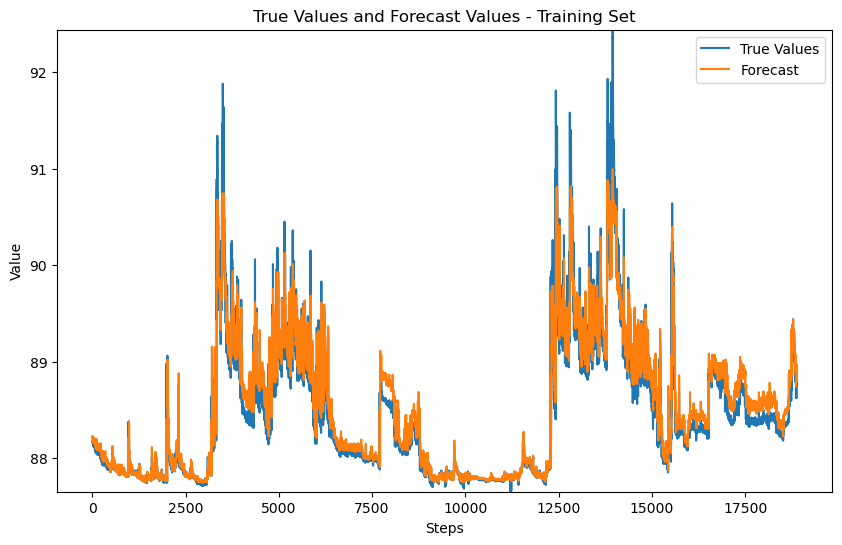

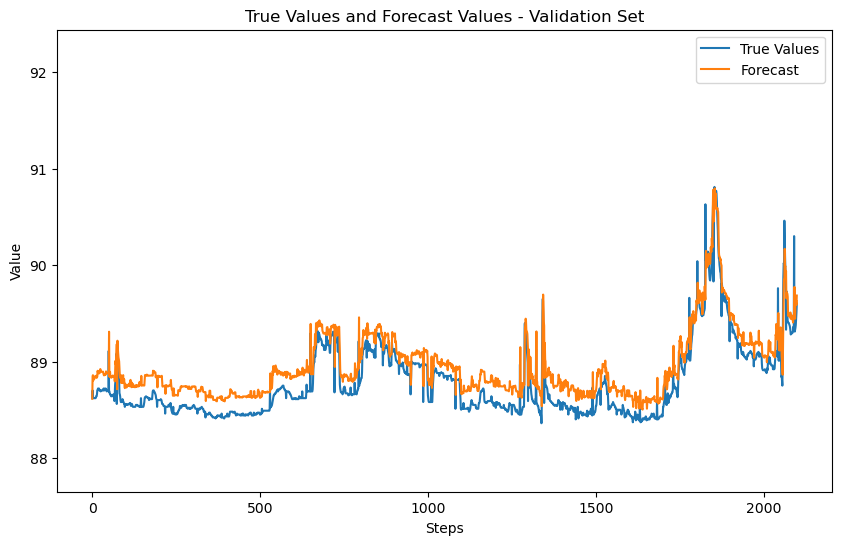

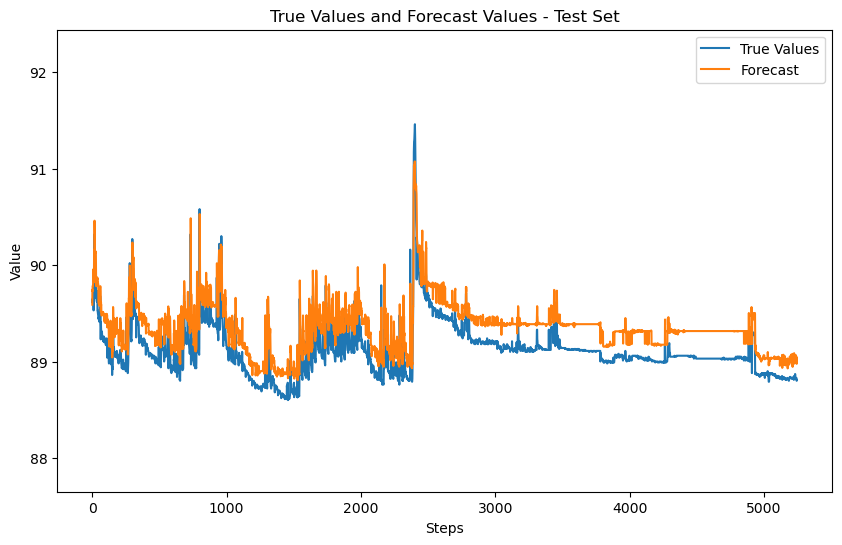

Important features:
1. 1510H057 Water Level - 878
2. 1510H057 Water Level_distance - 192
3. 1510H057 Water Level_T-1 - 336
4. 19335 Rainfall_T+1 - 125
5. 1510H057 Water Level_distance_T-23 - 106
6. 19335 Rainfall_T-6 - 65
7. 19335 Rainfall - 63
8. 1510H057 Water Level_distance_T-71 - 53
9. 1510H057 Water Level_distance_T-47 - 61
10. 19335 Rainfall_T-5 - 55
11. 1510H057 Water Level_T-23 - 44
12. 19335 Rainfall_24h_cumsum - 27
13. 19335 Rainfall_T-7 - 37
14. 1510H057 Water Level_T-71 - 40
15. 19335 Rainfall_6h_cumsum - 41
16. 1510H057 Water Level_distance_T-72 - 31
17. 1510H057 Water Level_distance_T-1 - 51
18. 19335 Rainfall_72h_cumsum - 48
19. 19335 Rainfall_T-1 - 20
20. 1510H057 Water Level_distance_T-24 - 50
21. 19335 Rainfall_T-55 - 43
22. 19335 Rainfall_T-4 - 44
23. 1510H057 Water Level_T-47 - 45
24. 19335 Rainfall_T-68 - 60
25. 19335 Rainfall_T-56 - 164
26. 19335 Rainfall_T-54 - 116
27. 19335 Rainfall_T-53 - 41
28. 1510H057 Water Level_T-2 - 32
29. 19335 Rainfall_48h_cumsum - 58
3

In [16]:
# 設定隨機種子
seed_value = 42

# 分割數據集為訓練和測試集
train_size = int(len(scaled_data) * 0.8)
val_size = int(train_size * 0.1)
train_data = scaled_data[:train_size-val_size]
val_data = scaled_data[train_size-val_size:train_size]
test_data = scaled_data[train_size:]

X_train = train_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_train = train_data["1510H057 Water Level_target_1"]

X_val = val_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_val = val_data["1510H057 Water Level_target_1"]

X_test = test_data.drop(["1510H057 Water Level_target_1"], axis=1)
y_test = test_data["1510H057 Water Level_target_1"]

# 訓練 LightGBM 模型
model = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=24,
    learning_rate=0.03366781071846638,
    n_estimators=675,
    max_bin=40,
    subsample=0.7124500581816137,
    subsample_freq=3,
    colsample_bytree=0.8784303388858438,
    min_child_samples=5,
    min_child_weight=10,
    verbose=0,
    device='gpu',
    random_state=seed_value
)
model.fit(X_train, y_train)

# 儲存模型和特徵名稱
if not os.path.exists("model"):
    os.makedirs("model")
dump(model, 'model/lgb_model.joblib')

# Save the feature names as a JSON file
with open('model/feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f)

WINDOW_SIZE = 144

# 定義多步預測函數
def recursive_forecast(model, X_test, y_test, steps=288):
    forecast = []          # 存儲預測結果的列表
    true_values = []       # 存儲真實目標值的列表
    r2_scores = []         # 存儲 R-squared 分數的列表
    mape_scores = []       # 存儲 MAPE 的列表

    X_test_copy = X_test.copy()  # 拷貝測試集特徵數據，以確保不修改原始數據
    
    for i in range(steps):
        features = X_test_copy.iloc[i].values.reshape(1, -1)  # 提取當前時間步的特徵數據並轉換為二維數組
        true_value = y_test.iloc[i]  # 提取當前時間步的真實目標值
        true_values.append(true_value)  # 將真實目標值添加到列表中

        pred = model.predict(features)  # 使用模型進行預測
        forecast.append(pred[0])        # 將預測結果添加到列表中

        if i < steps - 1:
            # 更新下一時間步的特徵數據，以使用先前的預測值進行預測
            X_test_copy.iloc[i + 1, -WINDOW_SIZE:] = np.hstack((X_test_copy.iloc[i, -WINDOW_SIZE:-1].values, [pred[0]]))

        # 計算當前時間步的 R-squared 分數並添加到列表中
        r2_scores.append(r2_score([true_value], [pred[0]]))

        # 計算當前時間步的 MAPE 並添加到列表中
        mape_scores.append(mean_absolute_percentage_error([true_value], [pred[0]]))

    return forecast, true_values, r2_scores, mape_scores

# 找到全局最大值和最小值
global_min = min(y_train.min(), y_val.min(), y_test.min())
global_max = max(y_train.max(), y_val.max(), y_test.max())

# 進行多步預測並評估結果
sets = [
    ("Training Set", X_train, y_train),
    ("Validation Set", X_val, y_val),
    ("Test Set", X_test, y_test)
]

for set_name, X, y in sets:
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X.reset_index(drop=True), y.reset_index(drop=True), steps=len(X))

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title(f'True Values and Forecast Values - {set_name}')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    plt.show()
    
# 取得重要特徵名稱與重要評分
feature_importances = model.feature_importances_
important_features = X_train.columns[feature_importances.argsort()[::-1]]

print("Important features:")
for i, feature_name in enumerate(important_features):
    print(f"{i+1}. {feature_name} - {feature_importances[important_features.get_loc(feature_name)]}")
    
print("-------------------------------------------------------------------------")
# 保存R²和MAPE得分到一個Excel文件
results_df = pd.DataFrame({
    'Step': list(range(1, len(X) + 1)),
    'R² Score': r2_scores,
    'MAPE Score': mape_scores
})

results_df.to_excel(f'{set_name.lower().replace(" ", "_")}_multi_step_forecast_results.xlsx', index=False)

print(f"R² and MAPE scores for {set_name} have been saved to '{set_name.lower().replace(' ', '_')}_multi_step_forecast_results.xlsx'")


In [ ]:
# # 將分割後的資料儲存到Excel文件中
# with pd.ExcelWriter('data_splits.xlsx') as writer:
#     train_data.to_excel(writer, sheet_name='Train Data', index=False)
#     val_data.to_excel(writer, sheet_name='Validation Data', index=False)
#     test_data.to_excel(writer, sheet_name='Test Data', index=False)

T+1 R²: nan, T+1 MAPE: 0.2781426583745201
T+1 to T+288 Average R²: nan, Average MAPE: 0.18244667861730937
The results have been saved to 'forecast_results.xlsx'


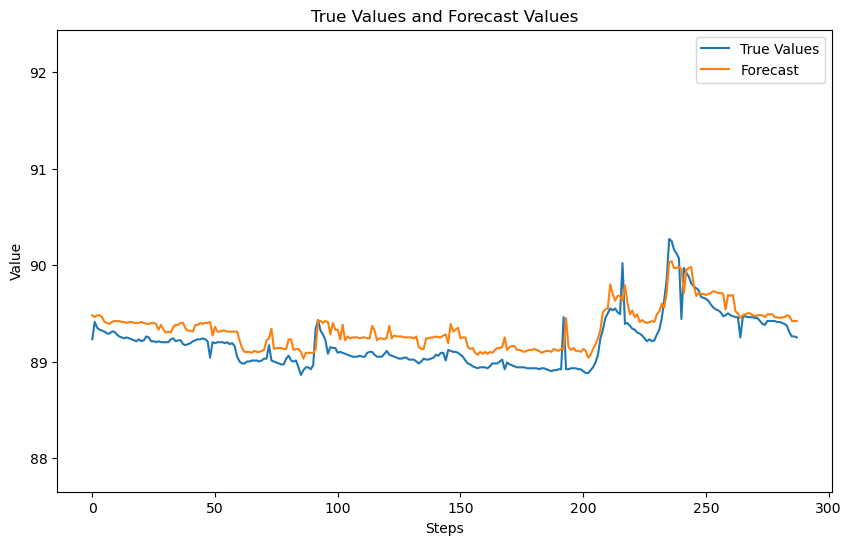

The recalculated R² scores have been saved to 'forecast_results.xlsx'


(array([89.48, 89.46, 89.48, 89.48, 89.46, 89.41, 89.4 , 89.39, 89.41,
        89.42, 89.42, 89.42, 89.41, 89.41, 89.4 , 89.41, 89.41, 89.4 ,
        89.4 , 89.4 , 89.41, 89.4 , 89.39, 89.39, 89.4 , 89.4 , 89.39,
        89.33, 89.38, 89.33, 89.3 , 89.31, 89.3 , 89.36, 89.38, 89.38,
        89.4 , 89.4 , 89.34, 89.32, 89.32, 89.31, 89.38, 89.38, 89.4 ,
        89.39, 89.4 , 89.4 , 89.41, 89.27, 89.36, 89.31, 89.31, 89.32,
        89.32, 89.31, 89.31, 89.31, 89.31, 89.31, 89.22, 89.14, 89.1 ,
        89.1 , 89.1 , 89.09, 89.11, 89.1 , 89.1 , 89.11, 89.12, 89.22,
        89.24, 89.34, 89.13, 89.14, 89.14, 89.14, 89.13, 89.13, 89.23,
        89.23, 89.12, 89.13, 89.13, 89.1 , 89.03, 89.09, 89.09, 89.09,
        89.09, 89.13, 89.42, 89.42, 89.4 , 89.42, 89.41, 89.28, 89.4 ,
        89.33, 89.33, 89.23, 89.38, 89.22, 89.26, 89.24, 89.25, 89.25,
        89.25, 89.24, 89.25, 89.25, 89.24, 89.24, 89.37, 89.32, 89.22,
        89.24, 89.24, 89.23, 89.25, 89.37, 89.24, 89.27, 89.26, 89.26,
      

In [17]:
from joblib import load
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error
import json

# 加载模型和特征名字
model = load('model/lgb_model.joblib')
with open('model/feature_names.json', 'r') as f:
    feature_names = json.load(f)
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    # 獲取對應的X_test和y_test
    X_test = scaled_data.iloc[idx_start:idx_end].drop(["1510H057 Water Level_target_1"], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end]["1510H057 Water Level_target_1"].reset_index(drop=True)

    # 進行多步預測
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test, steps=steps)

    # 四捨五入預測值到小數點後兩位
    forecast = np.round(forecast, 2)
    
    # T+1時刻的R²和MAPE
    r2_t1 = r2_scores[0]
    mape_t1 = mape_scores[0]

    # T+1到T+288的平均R²和MAPE
    avg_r2 = np.nanmean(r2_scores)
    avg_mape = sum(mape_scores) / len(mape_scores)

    print(f"T+1 R²: {r2_t1}, T+1 MAPE: {mape_t1}")
    print(f"T+1 to T+288 Average R²: {avg_r2}, Average MAPE: {avg_mape}")

    results_df = pd.DataFrame({
        'Step': list(range(1, steps + 1)),
        'True Values': true_values,
        'Forecast Values': forecast,
        'R² Score': r2_scores,
        'MAPE Score': mape_scores
    })

    with pd.ExcelWriter('forecast_results.xlsx') as writer:
        results_df[['Step', 'True Values', 'Forecast Values']].to_excel(writer, sheet_name='Values', index=False)
        results_df[['Step', 'R² Score', 'MAPE Score']].to_excel(writer, sheet_name='Scores', index=False)

    print("The results have been saved to 'forecast_results.xlsx'")
    
    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    plt.show()

    # 在函数的末尾添加以下代码来重新计算 R² 分数并保存回 Excel 文件
    values_df = pd.read_excel('forecast_results.xlsx', sheet_name='Values')
    
    # Calculate the cumulative R² score for each time point
    r2_scores_recalculated = [r2_score(values_df['True Values'][:i+1], values_df['Forecast Values'][:i+1]) for i in range(len(values_df))]

    # Add the recalculated R² scores as a new column in the DataFrame
    values_df['R² Score'] = r2_scores_recalculated

    # Save the DataFrame with the new R² scores back to the Excel file
    with pd.ExcelWriter('forecast_results.xlsx') as writer:
        values_df.to_excel(writer, sheet_name='Values', index=False)
        results_df[['Step', 'MAPE Score']].to_excel(writer, sheet_name='Scores', index=False)

    print("The recalculated R² scores have been saved to 'forecast_results.xlsx'")
    
    return forecast, true_values, r2_scores_recalculated, mape_scores

# 使用函數進行預測
forecast_from_timestamp('2022-05-29 23:00:00')

In [ ]:
from joblib import dump
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_absolute_error

def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    # 獲取對應的X_test和y_test
    X_test = scaled_data.iloc[idx_start:idx_end].drop(["1510H057 Water Level_target_1"], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end]["1510H057 Water Level_target_1"].reset_index(drop=True)

    # 進行多步預測
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test, steps=steps)

    # T+1時刻的R²和MAPE
    r2_t1 = r2_scores[0]
    mape_t1 = mape_scores[0]

    # T+1到T+288的平均R²和MAPE
    avg_r2 = np.nanmean(r2_scores)
    avg_mape = sum(mape_scores) / len(mape_scores)

    print(f"T+1 R²: {r2_t1}, T+1 MAPE: {mape_t1}")
    print(f"T+1 to T+288 Average R²: {avg_r2}, Average MAPE: {avg_mape}")

    # 真實值與預測值繪圖
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Steps')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 設定y軸的限制
    plt.show()

    return forecast, true_values, r2_scores, mape_scores

# 使用函數進行預測
forecast_from_timestamp('2022-05-29 23:00:00')



In [ ]:
def forecast_from_timestamp(timestamp_str, steps=288):
    timestamp = pd.to_datetime(timestamp_str)
    idx_start = data.index.get_loc(data.loc[data.index >= timestamp].index[0])
    idx_end = idx_start + steps

    # 获取对应的X_test和y_test
    X_test = scaled_data.iloc[idx_start:idx_end].drop(["1510H057 Water Level_target_1"], axis=1).reset_index(drop=True)
    y_test = scaled_data.iloc[idx_start:idx_end]["1510H057 Water Level_target_1"].reset_index(drop=True)

    # 进行多步预测
    forecast, true_values, r2_scores, mape_scores = recursive_forecast(model, X_test, y_test, steps=steps)

    # 真实值与预测值绘图
    plt.figure(figsize=(10,6))
    plt.plot(true_values, label='True Values')
    plt.plot(forecast, label='Forecast')
    plt.legend()
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.title('True Values and Forecast Values')
    plt.ylim(global_min, global_max)  # 设定y轴的限制
    plt.show()

    # 从scaled_data获取缩放的雨量数据
    scaled_rainfall = scaled_data.iloc[idx_start:idx_end]["19335 Rainfall"].values.reshape(-1,1)
    
    # 创建一个包含所有特征的缩放版本的新数据帧
    all_features_scaled = scaled_data.iloc[idx_start:idx_end].drop(["1510H057 Water Level_target_1"], axis=1).copy()
    
    # 用您想要反转缩放的值替换雨量特征列的值
    all_features_scaled["19335 Rainfall"] = scaled_rainfall.ravel()
    
    # 反标准化所有特征
    all_features_original = scaler.inverse_transform(all_features_scaled.values)
    
    # 获取反标准化的雨量特征列
    original_rainfall = all_features_original[:, scaled_data.columns.get_loc("19335 Rainfall")]

    # 为雨量创建一个新的图
    plt.figure(figsize=(10,6))
    
    # 绘制雨量数据
    plt.plot(data.index[idx_start:idx_end], original_rainfall, label='Rainfall')
    
    # 添加标签和标题
    plt.xlabel('Timestamp')
    plt.ylabel('Rainfall')
    plt.title('Rainfall Over Time')
    plt.legend()
    
    # 显示图
    plt.show()

    return forecast, true_values, r2_scores, mape_scores

# 使用新建的函数进行预测
forecast_from_timestamp('2022-05-29 23:00:00')
